# Practical Problem 1

### Kyle Goyette ID: 20085129
### Giancarlo Kerg ID: 20109271
### Alexandre Dos Santos ID: 20114844

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

import numpy as np
import matplotlib.pyplot as plt

### Creation of Helper Functions

Below are an assortment of functions used during the assignment. Each is described below:

In [4]:

# An MLP class with rigid 2 hidden layer, 800 hidden units architecture, using RELu's as the non-linearities
# Parameters: l2_reg: if None, applies no l2 regularization, otherwise applies l2 weight decay
#             dropout: the probability of droping a connection in the second hidden layer, if unentered no dropout is used
#             loss_crit: 
class MLP_MNIST(nn.Module):
    
    def __init__(self,loss_crit):
        super(MLP_MNIST,self).__init__()
        self.fc1 = nn.Linear(28*28,800)
        self.fc2 = nn.Linear(800,800)
        self.fc3 = nn.Linear(800,10)
        
        
        self.insize = 28*28
        
        self.loss_crit = loss_crit
        
        params = list(self.parameters())
        for param in params:
            if len(param.shape)>1:
                nn.init.xavier_normal(param)
            else:
                nn.init.constant(param,0)

    def forward(self,x):
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        a2 = self.fc2(h1)
        h2 = nn.functional.relu(a2)
        
        logits = self.fc3(h2)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices
    
    def calc_l2_norm(self):
        params = list(self.parameters())
        l2_norm = long(0)
        for param in params:
            if len(param.shape)>1:
                l2_norm +=  (torch.sum(torch.sum(torch.pow(param,2)))).data
            else:
                l2_norm += torch.sum(torch.pow(param,2)).data
        return torch.sqrt(l2_norm)
    
    def evaluate_model(self,loader):
        for batch_index,(inputs,targets) in enumerate(loader):
            x, targets = Variable(inputs.view([-1,self.insize])), Variable(targets)

            logits = self.forward(x)
            _, preds = self.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
        accuracy = (correct/float(total))
        return accuracy
        

    def train_model(self, train_data,optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None, verbose=True ):
        #prepare optimizer
        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_data,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]
        l2_norms=[] 
        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for batch_index, (inputs,targets) in enumerate(train_loader):
                inputs = Variable(inputs.view([-1,self.insize]))
                targets = Variable(targets)
                optimizer.zero_grad()
                logits = self.forward(inputs)
                _,preds = self.prediction(logits)
                correct += preds.eq(targets.data).sum()
                total += targets.size(0)
                
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])

                l2_norms.append(self.calc_l2_norm())
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = self.evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
        
                
            
            if (test_loader != None):
                test_acc = self.evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and epoch%20 ==0  and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True and epoch%20==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms)       



def make_data_loaders(train_data,batch_size,val_data=None,test_data=None):
    train_loader = torch.utils.data.DataLoader(train_data,batch_size,shuffle=True,num_workers=2)
    
    if (val_data != None): 
        val_loader = torch.utils.data.DataLoader(val_data,batch_size,shuffle=True,num_workers=2)
    else:
        val_loader = None
    if (test_data != None):
        test_loader = torch.utils.data.DataLoader(test_data,batch_size,shuffle=True,num_workers=2)
    else:
        test_loader = None
    return train_loader, val_loader, test_loader

def make_dataset(data,labels):
    data = torch.Tensor(data)
    labels = torch.IntTensor(labels)
    dataset = torch.utils.data.TensorDataset(data,labels)
    return dataset


        
            
        

## Preparing the Data

In [5]:

data_loc = '../data/mnist/mnist.pkl'
data = np.load(data_loc)
mnist_train_data = data[0][0]
mnist_train_labels = data[0][1]

mnist_train_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_train_data),torch.IntTensor(mnist_train_labels))

mnist_val_data = data[1][0]
mnist_val_labels = data[1][1]

mnist_val_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_val_data),torch.IntTensor(mnist_val_labels))


mnist_test_data = data[2][0]
mnist_test_labels = data[2][1]

train_dataset = make_dataset(mnist_train_data, mnist_train_labels)
val_dataset = make_dataset(mnist_val_data,mnist_val_labels)
test_dataset = make_dataset(mnist_test_data,mnist_test_labels)


In [6]:
print len(mnist_train_labels)

50000


## P1.a  Regularization : weight decay, early stopping, dropout, domain prior knowledge


In [59]:
lr = 0.02
batch_size=64
num_epochs=100
l2_reg = 0
batch_weight_decay = l2_reg/(float(len(mnist_train_labels))/float(batch_size))
print batch_weight_decay

No_reg_model = MLP_MNIST(loss_crit=nn.CrossEntropyLoss())
optimizer = torch.optim.SGD(No_reg_model.parameters(),lr=lr )
bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms = No_reg_model.train_model(train_dataset,optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None )

0.0
Epoch : 1 Loss : 0.611  Train Accuracy: 0.852
Epoch : 2 Loss : 0.291  Train Accuracy: 0.918
Epoch : 3 Loss : 0.237  Train Accuracy: 0.933
Epoch : 4 Loss : 0.203  Train Accuracy: 0.943
Epoch : 5 Loss : 0.176  Train Accuracy: 0.949
Epoch : 6 Loss : 0.155  Train Accuracy: 0.956
Epoch : 7 Loss : 0.139  Train Accuracy: 0.961
Epoch : 8 Loss : 0.125  Train Accuracy: 0.965
Epoch : 9 Loss : 0.113  Train Accuracy: 0.969
Epoch : 10 Loss : 0.103  Train Accuracy: 0.971
Epoch : 11 Loss : 0.095  Train Accuracy: 0.974
Epoch : 12 Loss : 0.086  Train Accuracy: 0.976
Epoch : 13 Loss : 0.079  Train Accuracy: 0.979
Epoch : 14 Loss : 0.073  Train Accuracy: 0.980
Epoch : 15 Loss : 0.068  Train Accuracy: 0.982
Epoch : 16 Loss : 0.063  Train Accuracy: 0.984
Epoch : 17 Loss : 0.058  Train Accuracy: 0.985
Epoch : 18 Loss : 0.054  Train Accuracy: 0.986
Epoch : 19 Loss : 0.051  Train Accuracy: 0.987
Epoch : 20 Loss : 0.047  Train Accuracy: 0.988
Epoch : 21 Loss : 0.044  Train Accuracy: 0.989
Epoch : 22 Loss : 

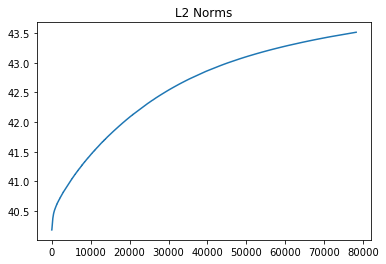

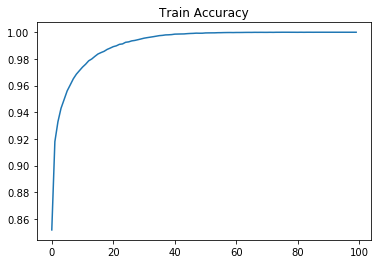

In [ ]:
plt.plot(l2_norms)
plt.title('L2 Norms')
plt.show()

plt.plot(train_accuracy)
plt.title('Train Accuracy')
plt.show()

In [ ]:
lr = 0.02
batch_size=64
num_epochs=100
l2_reg = 2.5
batch_weight_decay = l2_reg/(float(len(mnist_train_labels))/float(batch_size))
print batch_weight_decay

reg_model = MLP_MNIST(loss_crit=nn.CrossEntropyLoss())
optimizer = torch.optim.SGD(reg_model.parameters(),lr=lr,weight_decay = batch_weight_decay )
bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms = reg_model.train_model(train_dataset,optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None )

0.0032
Epoch : 1 Loss : 0.610  Train Accuracy: 0.855
Epoch : 2 Loss : 0.302  Train Accuracy: 0.915
Epoch : 3 Loss : 0.257  Train Accuracy: 0.929
Epoch : 4 Loss : 0.227  Train Accuracy: 0.937
Epoch : 5 Loss : 0.207  Train Accuracy: 0.944
Epoch : 6 Loss : 0.190  Train Accuracy: 0.948
Epoch : 7 Loss : 0.177  Train Accuracy: 0.951
Epoch : 8 Loss : 0.167  Train Accuracy: 0.955
Epoch : 9 Loss : 0.158  Train Accuracy: 0.957
Epoch : 10 Loss : 0.150  Train Accuracy: 0.959
Epoch : 11 Loss : 0.144  Train Accuracy: 0.962
Epoch : 12 Loss : 0.139  Train Accuracy: 0.963
Epoch : 13 Loss : 0.134  Train Accuracy: 0.965
Epoch : 14 Loss : 0.130  Train Accuracy: 0.967
Epoch : 15 Loss : 0.126  Train Accuracy: 0.968
Epoch : 16 Loss : 0.123  Train Accuracy: 0.969
Epoch : 17 Loss : 0.120  Train Accuracy: 0.970
Epoch : 18 Loss : 0.117  Train Accuracy: 0.970
Epoch : 19 Loss : 0.115  Train Accuracy: 0.971
Epoch : 20 Loss : 0.113  Train Accuracy: 0.972
Epoch : 21 Loss : 0.110  Train Accuracy: 0.973
Epoch : 22 Loss

In [ ]:
plt.plot(l2_norms)
plt.title('L2 Norms')
plt.show()

plt.plot(train_accuracy)
plt.title('Train Accuracy')
plt.show()

## 1.b Dropout

In [55]:
class Dropout_MLP(nn.Module):
    def __init__(self, dropout):
        super(Dropout_MLP,self).__init__()
        self.fc1 = nn.Linear(28*28,800)
        self.fc2 = nn.Linear(800,800)
        self.dropout = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(800,10)
        
        self.insize = 28*28
        
        self.loss_crit = nn.NLLLoss()
        
        params = list(self.parameters())
        for param in params:
            if len(param.shape)>1:
                nn.init.xavier_normal(param)
            else:
                nn.init.constant(param,0)
                
                
    def forward(self,x):
        lsm = nn.LogSoftmax(1)
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        a2 = self.fc2(h1)
        d2 = self.dropout(a2)
        h2 = nn.functional.relu(d2)
        
        logits = self.fc3(h2)
        probs = lsm(logits)
        
        return probs
    def predictions(self,x,eval_type, N=1):
        self.train()
        lsm = nn.Softmax(1)
        if eval_type == 'average_pre':
            averages = torch.zeros(x.shape[0],10)
        elif eval_type=='average_preds':
            averages = torch.zeros(x.shape[0])
        for i in range(N):

            a1 = self.fc1(x)
            h1 = nn.functional.relu(a1)
        
            a2 = self.fc2(h1)
            if eval_type == 'half':
                self.eval()
                d2 = a2
            else:
                d2 = self.dropout(a2)
            h2 = nn.functional.relu(d2)
            if (eval_type == 'half'):
                h2 = h2*0.5
                logits = self.fc3(h2)
                probs = lsm(logits)
                _,preds = torch.max(probs.data,1)
                return preds
            elif (eval_type == 'average_pre'):
                logits = self.fc3(h2)
                averages += logits.data
            elif (eval_type == 'average_preds'):
                logits = self.fc3(h2)
                probs = lsm(logits)
                _,preds = torch.max(probs.data,1)
                preds = preds.type(torch.FloatTensor)
                averages += preds
            
        if (eval_type == 'average_pre'):
            averages = torch.div(averages,N)
            averages = Variable(averages)
            probs = lsm(averages)
            _, preds = torch.max(probs.data,1)
            return preds

        if (eval_type == 'average_preds'):
            preds = torch.div(averages,N)
            preds = torch.round(preds)
            preds = preds.type(torch.LongTensor)
            return preds

    
    def evaluate_model(self,loader,eval_type,N=1):
        correct=0
        total=0
        for batch_index,(inputs,targets) in enumerate(loader):
            x, targets = Variable(inputs.view([-1,self.insize])), Variable(targets)

            preds = self.predictions(x,eval_type,N)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
        accuracy = (correct/float(total))
        return accuracy
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices
    
    
    def train_model(self, train_data,optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None, verbose=True ):
        #prepare optimizer
        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_data,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]
        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for batch_index, (inputs,targets) in enumerate(train_loader):
                inputs = Variable(inputs.view([-1,self.insize]))
                targets = Variable(targets)
                optimizer.zero_grad()
                logits = self.forward(inputs)
                _,preds = self.prediction(logits)
                correct += preds.eq(targets.data).sum()
                total += targets.size(0)
                
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
        
                
            
            if (test_loader != None):
                test_acc = evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and verbose == True and epoch%10==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True and epoch%20==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True and epoch%10==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)       


In [56]:
lr = 0.02
batch_size=64
num_epochs=100
DropoutModel = Dropout_MLP(0.5)
optimizer = torch.optim.SGD(DropoutModel.parameters(),lr=lr )
results = DropoutModel.train_model(train_dataset,optimizer,batch_size, num_epochs)

Epoch : 1 Loss : 0.664  Train Accuracy: 0.816
Epoch : 11 Loss : 0.114  Train Accuracy: 0.967
Epoch : 21 Loss : 0.065  Train Accuracy: 0.981
Epoch : 31 Loss : 0.040  Train Accuracy: 0.989
Epoch : 41 Loss : 0.027  Train Accuracy: 0.993
Epoch : 51 Loss : 0.019  Train Accuracy: 0.995
Epoch : 61 Loss : 0.014  Train Accuracy: 0.997
Epoch : 71 Loss : 0.010  Train Accuracy: 0.998
Epoch : 81 Loss : 0.007  Train Accuracy: 0.999
Epoch : 91 Loss : 0.006  Train Accuracy: 0.999


In [57]:
Ns = [10*i for i in range(1,10)]
test_loader,_,_ = make_data_loaders(test_dataset,64,val_dataset,test_dataset)
half_acc = [0]*len(Ns)
pre_acc = [0]*len(Ns)
pred_acc = [0]*len(Ns)
for i,N in enumerate(Ns):
    half_acc[i] = DropoutModel.evaluate_model(test_loader,'half',N)
    pre_acc[i] = DropoutModel.evaluate_model(test_loader,'average_pre',N)
    pred_acc[i] = DropoutModel.evaluate_model(test_loader,'average_preds',N)

## 1.b.i-iii Accuracy Plots for different Dropout evaluation procedures

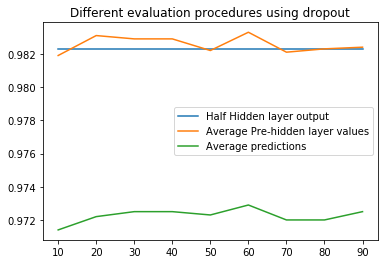

In [58]:
plt.plot(Ns,half_acc, label='Half Hidden layer output')
plt.plot(Ns,pre_acc, label='Average Pre-hidden layer values')
plt.plot(Ns,pred_acc,label='Average predictions')
plt.legend()
plt.title('Different evaluation procedures using dropout')
plt.show()

The different types of ensemble procedures shown here are:

i) When halving the output of the dropout mask, one can conclude that this is a bagging method. As shown during theory, this is a geometric mean of N different networks.

ii) This method can be closely related to the arithmetic mean of the logit outputs. Similar to boosting.

iii) This is also an arithmetic mean of the post softmax values, again similar to boosting.

### 1.c Convolutional Networks

In [9]:
class ConvNet(nn.Module):
    def __init__(self,batch_norm=False):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3), padding=1)
        if (batch_norm):
            self.bnorm1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(p=0.5)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2)

        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3), padding=1)
        if (batch_norm):
            self.bnorm2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(p=0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2)

        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3), padding=1)
        if (batch_norm):
            self.bnorm3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2),stride=2)

        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3), padding=1)
        if (batch_norm):
            self.bnorm4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2),stride=2)

        self.fc = nn.Linear(128,10)
        self.batch_norm=batch_norm
        #self.indims = [-1,1,28,28]
        
        self.loss_crit = nn.CrossEntropyLoss()
        
    def forward(self,x):
        a1 = self.conv1(x)
        d1 = self.dropout1(a1)
        if (self.batch_norm):
            d1 = self.bnorm1(d1)
        d1 = nn.functional.relu(d1)
        p1 = self.pool1(d1)
        
        a2 = self.conv2(p1)
        d2 = self.dropout2(a2)
        if (self.batch_norm):
            d2 = self.bnorm1(d2)
        d2 = nn.functional.relu(d2)
        p2 = self.pool2(d2)
        
        a3 = self.conv3(p2)
        d3 = self.dropout3(a3)
        if (self.batch_norm):
            d3 = self.bnorm1(d3)
        d3 = nn.functional.relu(d3)
        p3 = self.pool3(d3)
        
        a4 = self.conv4(p3)
        d4=self.dropout4(a4)
        if (self.batch_norm):
            d4 = self.bnorm1(d4)
        d4 = nn.functional.relu(d4)
        p4 = self.pool4(d4)
        
        logits = self.fc(p4.squeeze())
        
        return logits
    
    def prediction(self,logits):
        
        _, preds = torch.max(logits.data,1)
        
        return preds
    
    def evaluate_model(self,loader):
        correct = 0
        total = 0
        for batch_index,(inputs,targets) in enumerate(loader):
            x, targets = Variable(inputs.view([-1,1,28,28])), Variable(targets)

            logits = self.forward(x)
            preds = self.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
        accuracy = (correct/float(total))
        return accuracy
    
    def train_model(self, train_data, optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None, verbose=True ):
        #prepare optimizer
        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_data,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]
        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for batch_index, (inputs,targets) in enumerate(train_loader):
                inputs = Variable(inputs.view([-1,1,28,28]))
                targets = Variable(targets)
                optimizer.zero_grad()
                logits = self.forward(inputs)
                preds = self.prediction(logits)
                correct += preds.eq(targets.data).sum()
                total += targets.size(0)
                
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = self.evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
        
                
            
            if (test_loader != None):
                test_acc = self.evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True and epoch%20==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True and epoch%20==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms)

In [390]:
print mnist_train_data.shape

(50000, 784)


In [391]:
mnist_train_data_r = mnist_train_data.reshape((mnist_train_data.shape[0],28,28))
mnist_val_data_r = mnist_val_data.reshape((mnist_val_data.shape[0],28,28))
mnist_test_data_r = mnist_test_data.reshape((mnist_test_data.shape[0],28,28))

mnist_ctrain_dataset = make_dataset(mnist_train_data_r,mnist_train_labels)
mnist_cval_dataset = make_dataset(mnist_val_data_r, mnist_val_labels)
mnist_ctest_dataset = make_dataset(mnist_test_data_r, mnist_test_labels)


In [392]:
lr = 0.00001
batch_size = 64
num_epochs = 10
loss_crit = nn.CrossEntropyLoss()
MNIST_ConvNet = ConvNet()
optimizer = torch.optim.SGD(MNIST_ConvNet.parameters(),lr=lr)
train_results = MNIST_ConvNet.train_model(mnist_ctrain_dataset,optimizer, batch_size,num_epochs, val_data = mnist_cval_dataset, test_data = mnist_ctest_dataset)

Epoch : 1 Loss : 2.294  Train Accuracy: 0.133 Validation Accuracy: 0.155 Test Accuracy: 0.145
Epoch : 2 Loss : 2.032  Train Accuracy: 0.289 Validation Accuracy: 0.480 Test Accuracy: 0.461
Epoch : 3 Loss : 1.118  Train Accuracy: 0.624 Validation Accuracy: 0.727 Test Accuracy: 0.733
Epoch : 4 Loss : 0.704  Train Accuracy: 0.773 Validation Accuracy: 0.827 Test Accuracy: 0.818
Epoch : 5 Loss : 0.521  Train Accuracy: 0.836 Validation Accuracy: 0.863 Test Accuracy: 0.860
Epoch : 6 Loss : 0.457  Train Accuracy: 0.857 Validation Accuracy: 0.880 Test Accuracy: 0.885
Epoch : 7 Loss : 0.435  Train Accuracy: 0.870 Validation Accuracy: 0.882 Test Accuracy: 0.889
Epoch : 8 Loss : 0.401  Train Accuracy: 0.881 Validation Accuracy: 0.885 Test Accuracy: 0.885
Epoch : 9 Loss : 0.418  Train Accuracy: 0.881 Validation Accuracy: 0.880 Test Accuracy: 0.883
Epoch : 10 Loss : 0.405  Train Accuracy: 0.881 Validation Accuracy: 0.893 Test Accuracy: 0.895


In [393]:
lr = 0.001
batch_size = 64
num_epochs = 10
loss_crit = nn.CrossEntropyLoss()
BN_MNIST_ConvNet = ConvNet(batch_norm=True)
optimizer = torch.optim.SGD(BN_MNIST_ConvNet.parameters(),lr=lr)
train_results = MNIST_ConvNet.train_model(mnist_ctrain_dataset,optimizer, batch_size,num_epochs, val_data = mnist_cval_dataset, test_data = mnist_ctest_dataset)

Epoch : 1 Loss : 0.408  Train Accuracy: 0.884 Validation Accuracy: 0.892 Test Accuracy: 0.894
Epoch : 2 Loss : 0.402  Train Accuracy: 0.886 Validation Accuracy: 0.895 Test Accuracy: 0.891
Epoch : 3 Loss : 0.413  Train Accuracy: 0.885 Validation Accuracy: 0.899 Test Accuracy: 0.893
Epoch : 4 Loss : 0.404  Train Accuracy: 0.886 Validation Accuracy: 0.897 Test Accuracy: 0.894
Epoch : 5 Loss : 0.405  Train Accuracy: 0.886 Validation Accuracy: 0.896 Test Accuracy: 0.894
Epoch : 6 Loss : 0.400  Train Accuracy: 0.886 Validation Accuracy: 0.894 Test Accuracy: 0.896
Epoch : 7 Loss : 0.398  Train Accuracy: 0.887 Validation Accuracy: 0.894 Test Accuracy: 0.899
Epoch : 8 Loss : 0.415  Train Accuracy: 0.886 Validation Accuracy: 0.902 Test Accuracy: 0.897
Epoch : 9 Loss : 0.397  Train Accuracy: 0.886 Validation Accuracy: 0.895 Test Accuracy: 0.894
Epoch : 10 Loss : 0.402  Train Accuracy: 0.887 Validation Accuracy: 0.899 Test Accuracy: 0.895
